In [1]:
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModel, AutoTokenizer, Trainer, TrainingArguments
import matplotlib.pyplot as plt
from fracture_dataset import FractureDataset
from utils import compute_metrics, compute_additional_metrics, plot_confusion_matrix, compute_all_metrics_with_ci

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
root_dir = "AI FRACTURES"

tokenizer = AutoTokenizer.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")

with open("fracture_data_split.pkl", "rb") as f:
    split_data = pickle.load(f)

train_dataset = FractureDataset(split_data["train"], split_data["train_labels"], root_dir, image_transform=None, tokenizer=tokenizer)
test_dataset = FractureDataset(split_data["test"], split_data["test_labels"], root_dir, image_transform=None, tokenizer=tokenizer)
val_dataset = FractureDataset(split_data["val"], split_data["val_labels"], root_dir, image_transform=None, tokenizer=tokenizer)

In [3]:
class Model_TinyBert(nn.Module):
    def __init__(self, num_labels=1):
        super(Model_TinyBert, self).__init__()

        self.tinybert = AutoModel.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")

        # Freeze the TinyBERT model parameters
        for param in self.tinybert.parameters():
            param.requires_grad = False

        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.tinybert.config.hidden_size, num_labels)

        self.num_labels = num_labels


    def forward(self, input_ids, attention_mask, labels=None, output_attentions=None):
        outputs = self.tinybert(input_ids=input_ids, attention_mask=attention_mask, output_attentions=True)
        pooled_output = outputs.last_hidden_state[:, 0]
        logits = self.classifier(self.dropout(pooled_output))

        result = {"logits": logits}

        loss = None
        if labels is not None:
            loss = F.binary_cross_entropy_with_logits(logits, labels)
            result["loss"] = loss

        if output_attentions:
            result["text_attentions"] = outputs.attentions

        return result

In [4]:
model = Model_TinyBert(num_labels=1)

# Training setup
training_args = TrainingArguments(
    output_dir='./tinybert_fracture_output',
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy='epoch',
    learning_rate=1e-1,
    warmup_steps=200,
    lr_scheduler_type='cosine',
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    save_strategy="epoch",
    weight_decay=1e-4,
    logging_dir="./logs",
    logging_steps=10
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

C:\Users\ENVY\AppData\Local\Temp\ipykernel_18952\1675458573.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [6]:
trainer.train()
print('Training complete.')

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Roc Auc
1,0.699300,0.694486,0.500000,0.000000,0.500000
2,0.692700,0.679068,0.500000,0.000000,0.500000
3,0.677600,0.653017,0.500000,0.000000,0.500000
4,0.665700,0.616968,0.500000,0.000000,0.500000
5,0.653300,0.596326,0.800000,0.750000,0.800000
6,0.619800,0.547445,0.800000,0.750000,0.800000
7,0.641700,0.604089,0.800000,0.833333,0.800000
8,0.537200,0.511967,0.900000,0.888889,0.900000
9,0.618200,0.452322,0.800000,0.750000,0.800000
10,0.513200,0.766322,0.500000,0.666667,0.500000


c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: '

Training complete.


In [7]:
torch.save(model.state_dict(), "tinybert_fracture_model.pth")

In [8]:
# Save the model
trainer.save_model()

# Evaluate
trainer.evaluate()

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.5119670629501343,
 'eval_accuracy': 0.9,
 'eval_f1': 0.8888888888888888,
 'eval_roc_auc': 0.9,
 'eval_runtime': 0.1462,
 'eval_samples_per_second': 68.397,
 'eval_steps_per_second': 13.679,
 'epoch': 10.0}

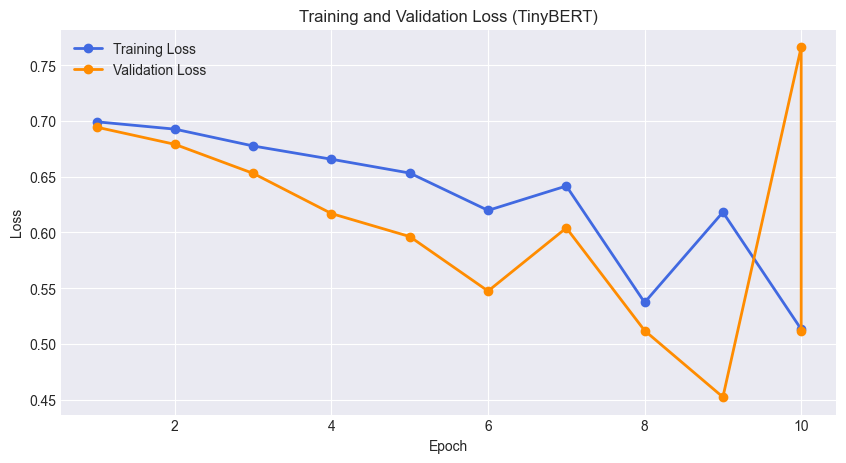

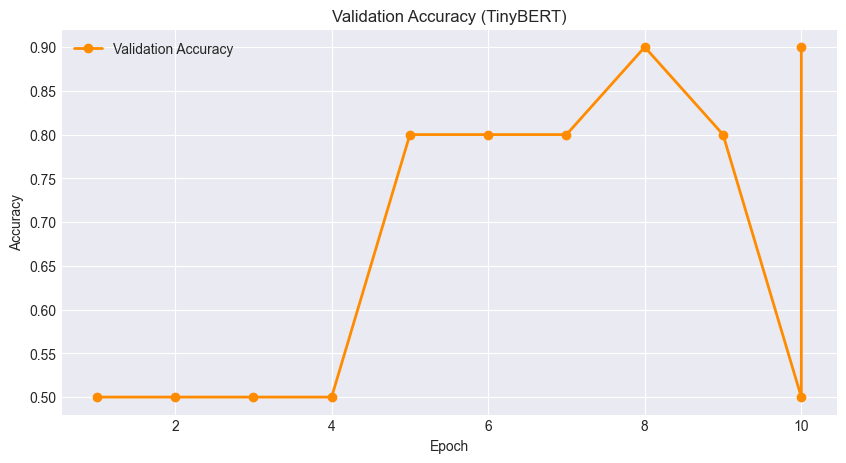

In [9]:
# Extract logs
logs = trainer.state.log_history

train_loss = []
eval_loss = []
eval_accuracy = []
train_epochs = []
eval_epochs = []

for log in logs:
    if "loss" in log and "epoch" in log and "eval_loss" not in log:
        train_loss.append(log["loss"])
        train_epochs.append(log["epoch"])
    if "eval_loss" in log:
        eval_loss.append(log["eval_loss"])
        eval_epochs.append(log["epoch"])  # store matching epoch
    if "eval_accuracy" in log:
        eval_accuracy.append(log["eval_accuracy"])

plt.style.use('seaborn-v0_8-darkgrid')
# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_epochs, train_loss, label="Training Loss", marker='o', linewidth=2, color='royalblue')
plt.plot(eval_epochs, eval_loss, label="Validation Loss", marker='o', linewidth=2, color='darkorange')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss (TinyBERT)")
plt.legend()
plt.grid(True)
plt.savefig("tinybert_fracture_loss.png")
plt.show()

# Plot Accuracy (optional, if accuracy was computed)
if eval_accuracy:
    plt.figure(figsize=(10, 5))
    plt.plot(eval_epochs[:len(eval_accuracy)], eval_accuracy, label="Validation Accuracy", marker='o', linewidth=2, color='darkorange')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy (TinyBERT)")
    plt.legend()
    plt.grid(True)
    plt.savefig("tinybert_fracture_accuracy.png")
    plt.show()

In [5]:
model.load_state_dict(torch.load("tinybert_fracture_model.pth"))
# Evaluate on test set
trainer.evaluate(test_dataset)

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


{'eval_loss': 0.44432562589645386,
 'eval_model_preparation_time': 0.003,
 'eval_accuracy': 0.9,
 'eval_f1': 0.8888888888888888,
 'eval_roc_auc': 0.9,
 'eval_runtime': 0.1763,
 'eval_samples_per_second': 56.73,
 'eval_steps_per_second': 11.346}

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


f1: 0.9091
roc_auc: 0.9000
matthews_corrcoef: 0.8165
brier_score: 0.1000
sensitivity: 1.0000
specificity: 0.8000
balanced_accuracy: 0.9000


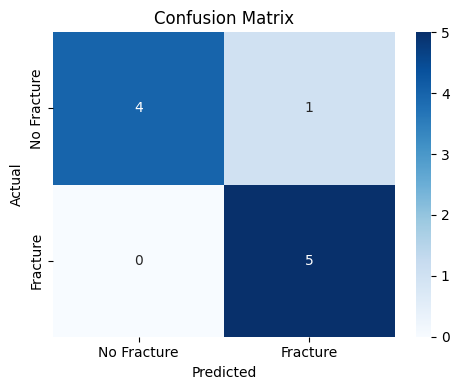

In [6]:
# Run evaluation
predictions = trainer.predict(test_dataset)

# Extract logits and compute probabilities using sigmoid if binary
logits = predictions.predictions
y_pred_probs = 1 / (1 + np.exp(-logits))  # Sigmoid for binary
y_pred_probs = y_pred_probs.squeeze()    # Remove extra dimension if needed
y_pred = (y_pred_probs >= 0.5).astype(int)  # Get predicted class labels

# Ground truth labels
y_true = predictions.label_ids.squeeze()

# Compute and print metrics
metrics = compute_additional_metrics(y_true, y_pred)
for key, value in metrics.items():
    if key != "confusion_matrix":
        print(f"{key}: {value:.4f}")

# Plot confusion matrix
plot_confusion_matrix(metrics["confusion_matrix"])

In [9]:
print("Confidence scores for test set:")
for i, score in enumerate(y_pred_probs):
    if y_pred[i] == 1:
        print(f"Report {i+1}: {score:.4f} confidence for fracture")
    else:
        print(f"Report {i+1}: {1-score:.4f} confidence for no fracture")

Confidence scores for test set:
Report 1: 0.6441 confidence for fracture
Report 2: 0.5920 confidence for fracture
Report 3: 0.6190 confidence for no fracture
Report 4: 0.7584 confidence for fracture
Report 5: 0.8353 confidence for fracture
Report 6: 0.6066 confidence for fracture
Report 7: 0.5702 confidence for no fracture
Report 8: 0.7539 confidence for fracture
Report 9: 0.6880 confidence for no fracture
Report 10: 0.6359 confidence for no fracture


In [12]:
results = compute_all_metrics_with_ci(y_true, y_pred, y_prob=y_pred_probs, multilabel=False)

for metric, (mean_val, (low, high)) in results.items():
    if mean_val is not None:
        print(f"{metric}: {mean_val:.3f} (90% CI: {low:.3f} - {high:.3f})")
    else:
        print(f"{metric}: Not available")

c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Error computing sensitivity for bootstrap sample
not enough values to unpack (expected 4, got 1)


c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Error computing specificity for bootstrap sample
not enough values to unpack (expected 4, got 1)


c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


accuracy: 0.902 (90% CI: 0.700 - 1.000)
f1: 0.899 (90% CI: 0.667 - 1.000)
auroc: 1.000 (90% CI: 1.000 - 1.000)
mcc: 0.818 (90% CI: 0.535 - 1.000)
brier: 0.099 (90% CI: 0.000 - 0.300)
sensitivity: 1.000 (90% CI: 1.000 - 1.000)
specificity: 0.794 (90% CI: 0.500 - 1.000)
balanced_accuracy: 0.900 (90% CI: 0.750 - 1.000)


c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\ENVY\OneDrive - Università degli Studi di Milano\Uni\Thesis\Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [13]:
model = Model_TinyBert(num_labels=1)
model.eval()
model.load_state_dict(torch.load("tinybert_fracture_model.pth"))

<All keys matched successfully>

In [14]:
# from torchview import draw_graph

# sample_input = next(iter(train_dataset))
# dummy_inputs = {
#     "input_ids": sample_input["input_ids"].unsqueeze(0),  # Add batch dimension
#     "attention_mask": sample_input["attention_mask"].unsqueeze(0)  # Add batch dimension
# }

# # Pass the inputs to your model (unpack the dictionary)
# output = model(
#     input_ids=dummy_inputs["input_ids"],
#     attention_mask=dummy_inputs["attention_mask"]
# )

# model_graph = draw_graph(
#     model,
#     input_data={
#         "input_ids": dummy_inputs["input_ids"],
#         "attention_mask": dummy_inputs["attention_mask"]
#     },
#     graph_name='TinyBERT Fracture Model Graph',
#     save_graph=True,
#     expand_nested=False
# )